In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from time import time

import mne
from mne.preprocessing import ICA, create_eog_epochs
from mne.channels import combine_channels

In [12]:
#Read raw data with MNE
raw = mne.io.read_raw_eeglab('./6/6.set', preload=False)
raw.pick_types(meg=False, eeg=True, eog=False).load_data()

reject = dict(eeg=180e-6)
raw.drop_channels(['ExG 1','ExG 2', 'A2','Packet Counter', 'TRIGGER'])  # 사용하지 않는 Channel 제거

#Get event code from annotations
events, events_id = mne.events_from_annotations(raw, event_id='auto')

events_id

Reading c:\Users\jinwook\Desktop\P3_ADJUST\6\6.fdt
Reading 0 ... 403235  =      0.000 ...   806.470 secs...
Used Annotations descriptions: ['10', '101', '102', '11']


{'10': 1, '101': 2, '102': 3, '11': 4}

In [13]:
# Sensor Location (Topological)
# https://mne.tools/stable/auto_tutorials/intro/plot_40_sensor_locations.html#sphx-glr-auto-tutorials-intro-plot-40-sensor-locations-py
montage = mne.channels.make_standard_montage(kind='standard_1020')  # 10-20 system montage
raw.set_montage(montage)

<RawEEGLAB | 6.fdt, 29 x 403236 (806.5 s), ~89.3 MB, data loaded>

In [14]:
#raw.notch_filter(50)
raw.filter(l_freq=0.5,h_freq=None,fir_design='firwin')   #high pass filter with fir filter
raw.filter(l_freq=None,h_freq=40,fir_design='firwin')    #low pass filter  with fir filter

raw.set_eeg_reference(ref_channels='average')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165 samples (0.330 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom E

<RawEEGLAB | 6.fdt, 29 x 403236 (806.5 s), ~89.3 MB, data loaded>

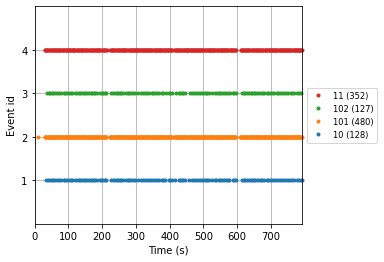

In [15]:
mne.viz.plot_events(events, event_id=events_id, sfreq=500)

events_id={'odd':1,'response':2,'dummy':3,'normal':4}  #redifine the events_id
events = mne.pick_events(events, include=[1, 2, 3, 4])  #pick events  that we interested

In [16]:
ica=ICA(n_components=29, method='fastica', random_state=89).fit(raw)  #define the parameter of ica and fit it to epochs

#ica.exclude = [1, 2]  # details on how we picked these are omitted here
#ica.plot_properties(raw, picks=ica.exclude)
#ica.plot_sources(inst=raw)

orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)  # remove the component that we selected

Fitting ICA to data using 29 channels (please be patient, this may take a while)


<ipython-input-16-e5d38cce8e2d>:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica=ICA(n_components=29, method='fastica', random_state=89).fit(raw)  #define the parameter of ica and fit it to epochs


Selecting by number: 29 components
Fitting ICA took 10.6s.
Applying ICA to Raw instance
    Transforming to ICA space (29 components)
    Zeroing out 0 ICA components
    Projecting back using 29 PCA components


<ipython-input-16-e5d38cce8e2d>:1: RuntimeWarning: Using n_components=29 (resulting in n_components_=29) may lead to an unstable mixing matrix estimation because the ratio between the largest (23) and smallest (7.5e-30) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 28
  ica=ICA(n_components=29, method='fastica', random_state=89).fit(raw)  #define the parameter of ica and fit it to epochs


<RawEEGLAB | 6.fdt, 29 x 403236 (806.5 s), ~89.3 MB, data loaded>

Not setting metadata
Not setting metadata
1087 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1087 events and 351 original time points ...
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7', 'FC5']
    Rejecting  epoch based on EEG : ['F7', 'FC5']
    Rejecting  epoch based on EEG : ['Fp1', 'F7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF3', 'F7', 'Fz', 'F4', 'FC5', 'FC6']
7 bad epochs dropped


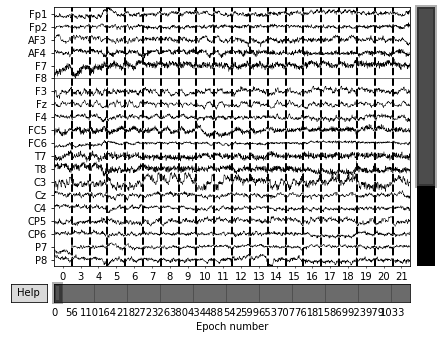

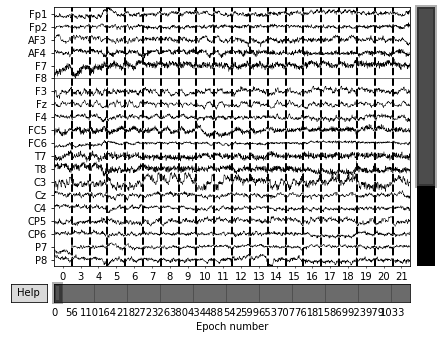

In [17]:
#epoch and reject those larger than 300 microvolt
epochs = mne.Epochs(raw,events=events, event_id=events_id, baseline=None, preload=True, tmin=-0.2, tmax=0.5, reject=dict(eeg=150e-6))

epochs
epochs.plot()

In [18]:
# Exclude Participant depending on the rejection. (Total epoch / rejected epoch)
if epochs.drop_log_stats() > 25:
    print("Exclude Participant!")


Applying baseline correction (mode: mean)


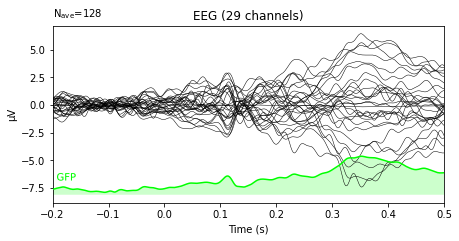

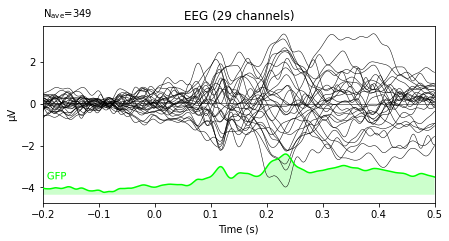

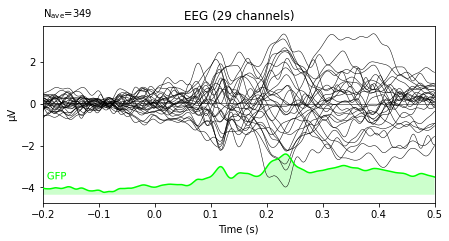

In [19]:
epochs.apply_baseline(baseline=(-0.2, 0))
 
evoked_normal = epochs['normal'].average()
evoked_odd = epochs['odd'].average()

evoked_odd.plot(gfp=True)
evoked_normal.plot(gfp=True)

combining channels using "mean"
combining channels using "mean"


<ipython-input-20-0d34a765072d>:3: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(condition_index, picks=['Pz'], ci=None, combine='mean',legend='lower right',show_sensors='upper left') #plot compared ERP


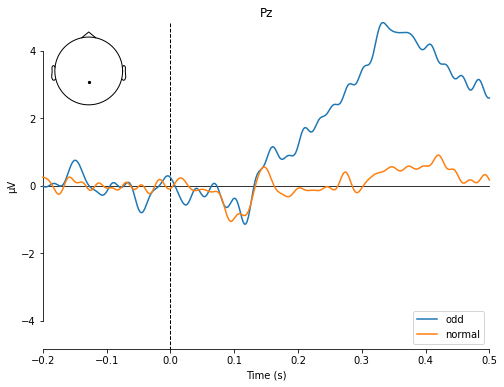

[<Figure size 576x432 with 2 Axes>]

In [20]:
condition_index={'odd':evoked_odd,'normal':evoked_normal} #set parameter for plot ERP

mne.viz.plot_compare_evokeds(condition_index, picks=['Pz'], ci=None, combine='mean',legend='lower right',show_sensors='upper left') #plot compared ERP